# Plant Seedlings Classification

## 1. Setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = os.path.join('data', 'sample') + '/'
#PATH = os.path.join('data') + '/'

In [4]:
ls {PATH}

models/ test/   tmp/    train/  valid/


If true, it means we will be able to utilize the GPU

In [5]:
torch.cuda.is_available()

False

If true, it means we will be able to utilize the GPU even better

In [6]:
torch.backends.cudnn.enabled

True

Since Mac keeps creating .DS_Store files I found a function for deleting it in the data directory.
Source: https://gist.github.com/mattsparks/19a0911999a623a3c302cc29c96b293a

In [7]:
def delete_ds_store():
    for root, dirs, files in os.walk(PATH):
        i = 0
        for file in files:
            if file.endswith('.DS_Store'):
                path = os.path.join(root, file)

                print("Deleting: %s" % (path))

                if os.remove(path):
                    print("Unable to delete!")
                else:
                    print("Deleted...")
                    i += 1

    print("Files Deleted: %d" % (i))


## 2. Exploratory analysis

### 2.1 Examining images

In [8]:
class_paths = glob(os.path.join(PATH, 'train', '*'))
class_names = [path.split('/')[-1] for path in class_paths]

Show two first images for each class to get the general idea how the data looks like.

/Users/michalstechly/Documents/Fast_AI/venv-fast-ai/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


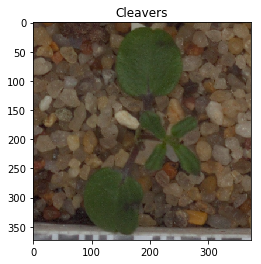

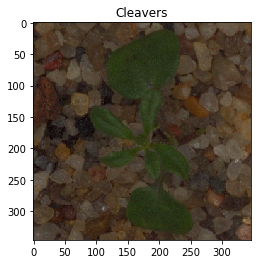

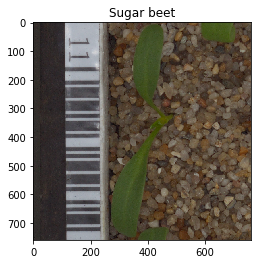

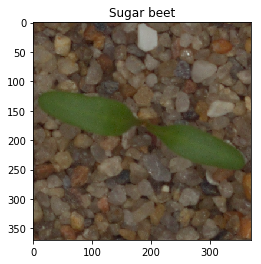

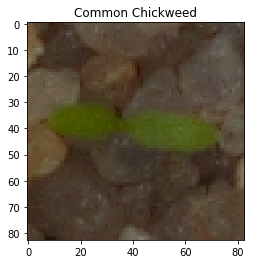

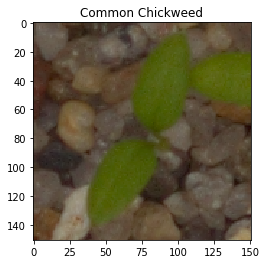

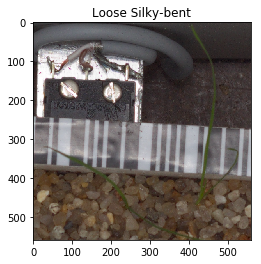

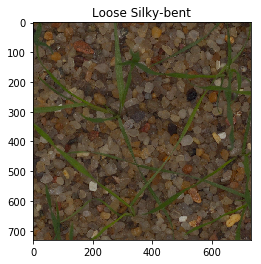

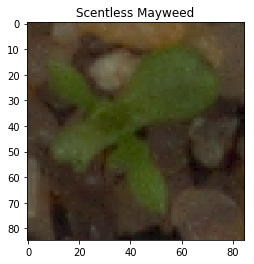

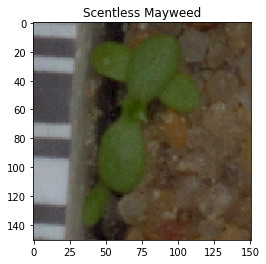

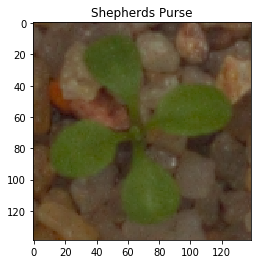

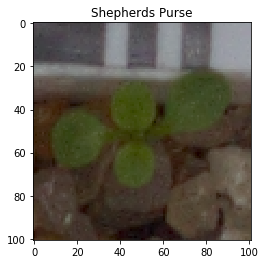

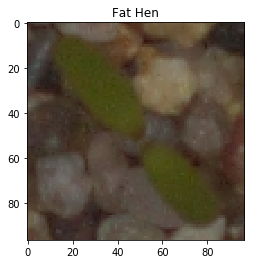

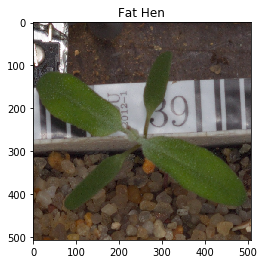

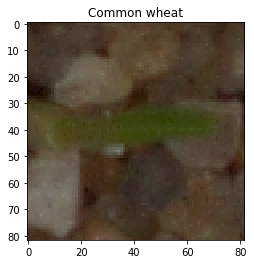

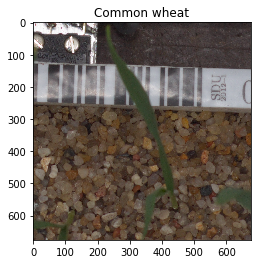

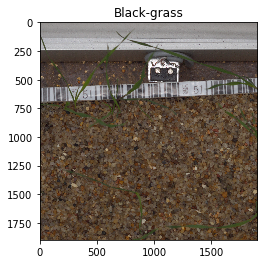

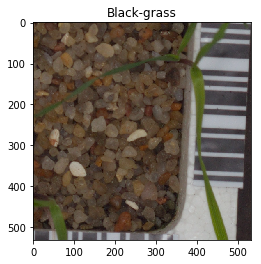

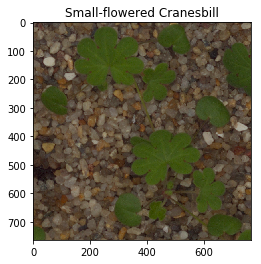

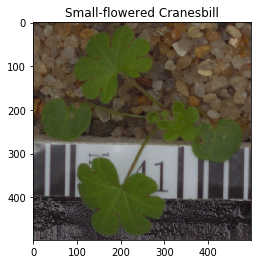

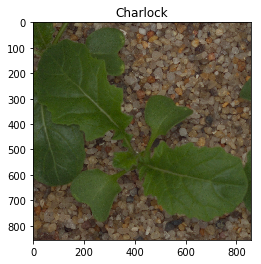

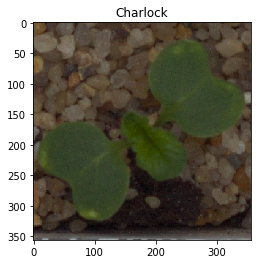

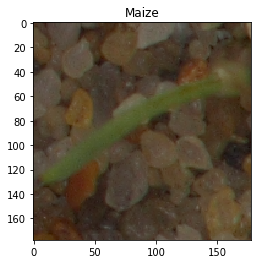

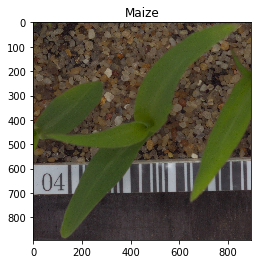

In [16]:
for class_name in class_names:
    files = glob(os.path.join(PATH, 'train', class_name)+'/*.png')
    for i in [0, 1]:
        img = plt.imread(files[i])
        plt.figure()
        plt.title(class_name)
        plt.imshow(img)

### 2.2 Image sizes

As we can see in the images above, they vary in size. 
Here I want to see how much.

In [9]:
raw_images = []
for class_name in class_names:
    files = glob(os.path.join(PATH, 'train', class_name)+'/*.png')
    for i in [0, 1]:
        raw_images.append(plt.imread(files[i]))

Each element of the raw_images list is a 3D array.
First two dimensions are height and width, and the third one is the RGB value of the image.

Checking if all the pictures are squared

In [19]:
not_square = []
for image in raw_images:
    not_square.append(image.shape[0] != image.shape[1])

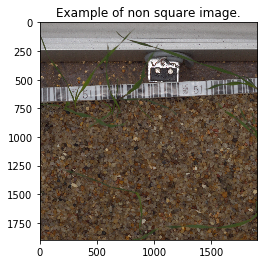

In [20]:
number_of_not_square = sum(not_square)
if number_of_not_square:
    not_square_images = np.array(raw_images)[not_square]
    plt.title("Example of non square image.")
    plt.imshow(not_square_images[0])

Since part of the images are not squared, when analyzing the size of the pictures I will take into the account the higher value form width and height.

In [21]:
sizes_list = []
for image in raw_images:
    sizes_list.append(max(image.shape))

Min size: 82
Max size: 1900


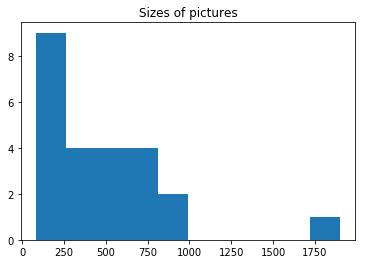

In [23]:
plt.title("Sizes of pictures")
plt.hist(sizes_list)
print("Min size:", min(sizes_list))
print("Max size:", max(sizes_list))

### 2.3 Conclusions

From the analysis so far, we can say that:
- Images vary in size (from 82 - 1900 pixels)
- Most, but not all of the images are square
- Photos seem to be taken from the top

## 3. Preparing the model

In [10]:
size = 64

In [11]:
delete_ds_store()

Files Deleted: 0


In [13]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, size))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[0.      2.87887 2.52415 0.16667]               
[1.      2.90671 2.47275 0.16667]               
[2.      2.84294 2.41714 0.16667]               



## 4. Examining the results

In [14]:
if 'sample' in PATH:
    visualization_size = 1
else:
    visualization_size = 4

In [46]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.amax(np.exp(log_preds),axis=1)

In [47]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], visualization_size, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)


In [48]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)


In [49]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds, x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))


Correctly classified


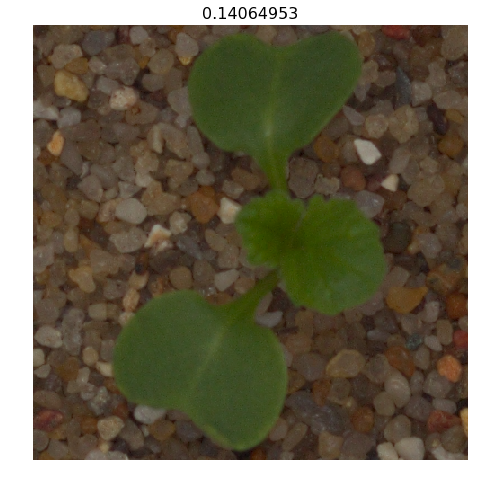

In [50]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")